# A Whirlwind Introduction to PEST(++)

In this notebook we introduce the automated parameter estimation tools PEST and PEST++. This introduction is far from comprehensive. Our goal here is to provide you the basics to understand the "plumbing" of how PEST interacts with a "model".

Recall that, for all its sophistication, automated parameter estimation software does the same things as a modeler does during manual trial-and-error.  It (1) assigns best guess parameter values, (2) runs the model, (3) compares model outputs to measured values, (4) if model-to-measurment fit is inadequate, it adjusts parameter values and repeats the process. Once model-to-meareument fit ceases to improve, it stops. As is implied by the name, all of these steps must be automated. All of the decision criteria must also be quantified and are recorded, making the process transparent and reproducible.

Here is a flow chart of manual trial-and-error history matching from *Applied Groundwater Modeling (2nd edition)* by Anderson et al. (2015): 

<img src="figs\Fig9.1_manual_t&e.png" style="float: center">

Compare this to the full overdetermined parameter estimation flow chart:

<img src="figs\Fig9.9_full_overdetermined_PE_flowchart.png" style="float: center">

To be more specific, in the blue box in Figure 9.9 above there are certain steps that occur before and after each forward model run that PEST does.  They exactly equate to what a manual trial-and-error calibration does, but PEST does it for you! Here are the steps that happen:

<img src="figs\Fig9.8_PE_flowchart.png" style="float: center">

### 1. The PEST Input Dataset

PEST and PEST++ are called "universal" inverse codes because they can be bolted on the outside of any model.  Well, that is, any model they can talk to and run, which means the model needs to meet these two criteria:

 1. The model input and output are ASCII text files or can be converted to text files.
 2. The model can be run at the command line without user intervention (also known as "batch mode").

In this exercise we will get under the hood and see how PEST communicates with the model. To do all of this we need to build a PEST input dataset, which is comprised of three file types:

 - template files,
 - instruction files, and a
 - PEST control file.

Whenever PEST runs a model, it must first write parameter values to model input files. PEST requires
template files in order to know how to write model input files in ways that the model expects. By
convention, template files are provided with an extension of “.tpl”. A unique template file is required for each model input file that contains parameters which PEST must adjust.

After running the model, PEST must read observations from model output files. PEST requires instruction files in order to know where to find observation values in the output files. By convention, instruction files are provided with an extension ".ins". A single instruction file is required for each model output file which PEST must read.

For any particular PEST run there is only one PEST control file. As is implied by the name, the information in this file "controls" PEST behaviour. This file contains information on how PEST decides to update parameters, whether the fit is "good enough", where model input and output files are located, how to run the model and so on. The control file is divided into sections. Each section has a specifc format and layout in which variables can be included. Many of these variables can be assigned with default values and will only require adjustment in specifc cases. We will discuss the more pertinent (or common) ones as we progress through the various tutorials. The PEST and PEST++ user manuals provide further detail. Users are encouraged to take the time to read these documents. 

Most groundwater modelling graphical user interfaces (GUIs) support construction of PEST input
datasets of varying complexity. In many cases, PEST setup achieved in this way is fit for purpose.
However, no GUI is able to cater for every conceivable history-matching context. Hence there are
many contexts in which a user may need to construct their own PEST input dataset. Doing so in a programatic environment makes this process automatable, replicable and much less painfull. `pyEMU` provides a `python` based interface that facilitates PEST-based workflows.  In this tutorial we will start by construting some of the PEST dataset "manually" so that you become familiar with what goes on in the background. Then, we will begin to introduce the use of `pyEMU`. Other tutorials provide general overview to `pyEMU` (see the "intro to pyemu" notebook) and demonstrate how to build a high-dimensional PEST interface from scratch (see the "freyberg pstfrom pest setup" notebook). But we are getting ahead of ourselves - we will get to those notebooks further along in the course.

### 1.2. Additional Resources

Providing details on all of the functionality and intricacies of PEST and PEST++ in a single tutorial is not feasible. Here we introduce you to the basics. The following are usefull resources for further reading:

- GMDSI tutorials on using PEST(++) in a non-programatic workflow: https://gmdsi.org/education/tutorials/ 
- The PEST manual: https://pesthomepage.org/documentation
- The PEST book: https://pesthomepage.org/pest-book
- PEST tutorials: https://pesthomepage.org/tutorials
- The PEST++ user manual: https://github.com/usgs/pestpp/tree/master/documentation

### 1.3. Tutorial Objectives

1. During this tutorial we'll spend time on "the plumbing" that allows PEST to manipulate model input and output files (shown in the 1st and 3rd box in Figure 9.8).  
2. And - we'll run PEST++!
3. And we'll see how to include forecasts in our PEST runs

### 1.4. Admin

We have provided some pre-cooked PEST dataset files, wrpaped around the modeified Freyberg model. The functions in the next cell import required dependencies and prepare a folder for you. This folder contains the model files and a preliminary PEST setup. Run the cells, then inspect the new folder named "pest_files" which has been created in your tutorial directory. (Just press shift-enter to run the cells). 

In [5]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pyemu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;

sys.path.append("..")
# import pre-prepared convenience functions
import herebedragons as hbd

In [6]:
# the pest files folder
tmp_d = os.path.join('pest_files')

# run our convenience functions to prepare the PEST and model folder
hbd.prep_pest(tmp_d)

ins file for heads.csv prepared.
ins file for sfr.csv prepared.
noptmax:0, npar_adj:3, nnz_obs:26
written pest control file: pest_files\freyberg.pst


### 1.5. Reminder - the modified-Freyberg model
Just a quick reminder of what the model looks like and what we are doing. 

It is a 3D model, with three layers. A river runs north-south, represented with the SFR package (green cells in the figure). On the southern border there is a GHB (cyan cells). No-flow cells are shown in black. Pumping wells are placed in the bottom layer (red cells). 

Time-series of measured heads are available at the locations marked with black X's. River flux is also measured at three locations (headwater, tailwater and gage; not displayed).

The simulation starts with a steady state stress period, followed by twelve transient stress periods. These represent the historic period, for which measured data are available.

A subsequent twelve transient stress periods representing a period in the future. Modelling is undertaken to assess selected forecasts during the simulated period.

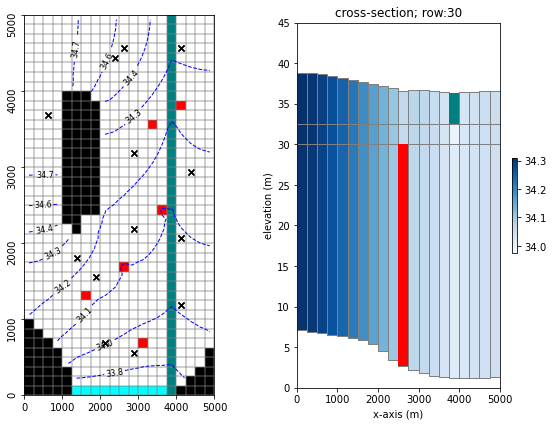

In [7]:
hbd.plot_freyberg(tmp_d)

In the previous tutorial on manual trial-and-error, we "manually" changed parameter values to get a good fit with measured data. We want PEST to this for us instead. To do so, we need to provide PEST with conduits that change a model input file and that extract model outputs after the model has been run. 

**In this tutorial you do not *have* to get your hands dirty. However, we recomend you do. We provide all the necessary files to advance through the tutorial without any user-input. However, getting to grips with how files are constructed and the inner-workings of PEST is often insightfull. Throught the notebook we will provide instructions to read and edit files manualy (yes, yes...we know...we will get back to good old python in due course). This will require the use of a text editor software. Generic text editors (e.g notepad on Windows) are sufficent, but you will benefit from more versatile software such as Notepad++, UltraEdit, etc. There are many free options available online.**


### 2. Template Files

Template files are used to create model input. Template files simply replace parameter numerical values with a code variable, named in the PEST Control File.

There needs to be one template file __for each model__ input file that has parameters that we want PEST to estimate. PEST will read in each template file,  use it as a template to substitute its updated parameter value, then write one model input file for each template file it read.  

In the PEST control file we specify each template file __and__ the associated model model input file we want PEST to create after it has updated estimates for the parameters on separate lines. So, say we had a MODFLOW input file named 'my_aquifer.lpf' for which we made a template file 'my_aquifer_lpf.tpl'. In the "model input/output" section of the PEST control file there will be a line containing this:

> `my_aquifer_lpf.tpl               my_aquifer.lpf`

Navigate to the tutorial folder (e.g. in a file manager application, such as Windows Explorer). There should be a new folder there named `pest_files`. In that folder, you will find a PEST control file named `freyberg.pst`. Open it in a text editor and find the template (tpl) files listed in the `*   model input/output` section. Open one of these template files in a text editor and take a look.

You should see four lines, each with a file name pair. They should look something like this:

>```
>freyberg6.npf_k_layer1.tpl freyberg6.npf_k_layer1.txt
>freyberg6.npf_k_layer2.tpl freyberg6.npf_k_layer2.txt
>freyberg6.npf_k_layer3.tpl freyberg6.npf_k_layer3.txt
>freyberg6.rch.tpl freyberg6.rch.txt
>```

The first file name in each row is a template file. The second is the corresponding model input file. Open up the two files named in the first row in your text editor software and compare them.

### 2.1. Rules for constructing TPL Files 

 1. The first line of the TPL file must identify that it is a template file by listing "`ptf ~`" where "`~`" is a "parameter delimiter" that tells PEST where a parameter sits in the file. We used a tilde here, but it can be any symbol. __However__, whatever delimiter symbol is listed in the first line must be used consistently throughout that template file.
 
 2. The template file looks exactly like the original model input file __BUT__ parameters are substituted for the  model input(s) that we want PEST to estimate.  Parameters are identified by surrounding the parameter name listed in the PEST control (.pst) file with the delimiter.  For the "`~`" delimiter that we used above, and a horizontal K parameter named "`hk1`" listed as a parameter in a PEST .pst file, the template file would have "`~   hk1 ~`" __wherever that Kh value__ was listed in the original model input file. 
   * Note that the parameter name can be anywhere between the parameter delimiters
   * PEST will fill the space up to and including the parameter delimiters with a value, so make them as wide as possible for maximum precision
   
**So!** 

"`~    hk1    ~`" will be replaced by the value for `hk1` specified by PEST. If that value is 3.14, PEST will write "`3.14000000000`" in its place.

>**Note**: 
The PEST manual explains more detail about how you can control the writing of model input (e.g. scientific notation, double precision, etc.); see http://www.pesthomepage.org/Downloads.php to get the most recent version of the manual.

### 2.2. Checking a template file with the `TEMPCHEK` utility

Let's check to see if this template file is correct using TEMPCHEK.  

TEMPCHEK is a handy PEST utility that allows us to error check our template files without having to do a full PEST run. You can see exactly what files and what order TEMPCHECK is expecting them by simply typing 'TEMPCHEK" at the command line (tempchek for Windows and ./tempchek for Mac). 

Open up a command line in the `pest_files` folder and run TEMPCHEK. You'll see:

>```
>TEMPCHEK Version 14.01. Watermark Numerical Computing.
>
>TEMPCHEK is run using the command:
>
>   tempchek tempfile [modfile [parfile]]
>
>where
>
>   "tempfile" is a PEST template file,
>   "modfile" is an [optional] model input file to be written by TEMPCHEK, and
>   "parfile" is an [optional] parameter value file.
>
>```


Run `TEMPCHEK` __on the template file listed in  `freyberg.pst`__ and open the associated output file listed.  Although you could have seen this on a quick look at the template file, the TEMPCHEK output file is useful when you have many parameters. It will also notify you of any problems with the template file.

### 2.3. Make your own TPL file

Test your understanding. Construct your own template file and check it with TEMPCHEK.

The easiest way to make a template file? Modify an existing input file. You can do for any moel input file. Suggest using `freyberg6.npf_k_layer1.txt` so you can compare to the provided template file.

 1. Open the input file in a text editor
 2. Make a copy of the input file with a new name and with .tpl extension (ex.: `test.tpl`; normaly we use the same file name as the input file, and just change the extension. Just make sure not to use the same name as we did.)
 5. Add a new line at the top of your tpl file to tell PEST that it is a template file and what the delimiter is
 6. Do a search and replace, subsituting the variable "hk1" surrounded by the delimiter you chose where appropriate
 7. Save the file and run TEMPCHEK 

### 3. Instruction files

Similar to the template files, the names of instruction files and which model output files they should work on are listed after all the template files in the "* model input/output" section of the PEST control file.  As you might expect with the wide range of model output file variation, creating instruction files is slightly more complicated than creating template files. There is basically an internal scripting language for reading text files of model output, extracting the output of interest, and providing it directly to PEST.

Open the PEST control file `freyberg.pst` in a text editor and find the Instruction (ins) file listed in the `model input/output` section. You should see something like:

>```
>heads.csv.ins heads.csv
>sfr.csv.ins sfr.csv
>```

Open one of these instruction file and model output file pairs in a text editor and inspect them. As you can see, the model output files are CSVs. With the exception of the first column, the values in each row and column of the CSV are observations. 

### 3.1. Rules for constructing INS Files 

 * The first line on an .ins file must be "`pif ~`" where "`~`" is a "marker delimiter"--a symbol that can be used to identify text to search for.  It is expected on this first line but it's not always used.
 * The scripting options are extensive but particular. Some options on how to navigate to the numerical data you want to read are:
   1. Using a line advance.  PEST starts at the very top the model output file, and you have to move down 1 line to get to the first line that you see in the model output. You can tell PEST to move down the file _`n`_ lines using the `l` character (=lowercase letter l) with a number.  So "`l1`" moves down one line, "`l3`" moves down 3 lines.  
   2. Using the marker delimiter, the INS file can search through a file until it finds a "primary marker". For example:  
   "`~VOLUMETRIC BUDGET FOR ENTIRE MODEL~`" can be used to search for budgets in a LST file  
   This is particularly well suited for output files (like a LST file) that have unpredictable lengths.  Note though that PEST will always start at the top of the file and go down, never up and never wrapping once it reaches the end.  This can be a problem when the order of some observations with respect to other observations is not consistent (e.g., some MODPATH output).  When searching for mutiple observations that may vary in order in an output file, it is easiest to have multiple instruction files open the same model output file multiple times so you are always starting at the top of the file (PEST does not mind). 
   3. Next, you can search for a "secondary marker" within a line using the marker delimiter again. This navigates from the left of the line until the secondary marker is found.
   4. Once on the line you can specify which columns on a line to extract.  So a line in an instruction file that says `~101  138~ (depth_T2-90)46:58` means that PEST will look for `101  138` in the model output file (with the exact number of spaces between the two numbers) then extract column `46:58` to determine the model output that equates to the target observation `depth_T2-90` that is listed in the PEST control file.   
5. Finally, you can read in whitespace-delimited numerical data using "`!`" around the observation name:  
   for example, if the output file is:  
      > ```
      > Output file from run 5
      > Run date: 1/1/2012
      > Run time: 24.3 hours
      > Converged in 350 iterations
      > Head Observations:
      > H1=33.345 H2=45.34
      > ...
      > ```  
      The instruction file would be like 
      >  ```
      > pif ~
      >  ~Head Observations~
      >  l1 ~H1=~ !h1val! ~H2=~ !h2val!
      > ```
  
These are only a few of the most commonly used options but more options, and more detail on these, are available in the PEST manual.  

### 3.2. Checking a template file with the `INSCHEK` utility

Let's check an instruction file using `INSCHEK`, a handy utility that allows us to check our instruction files without having to do a full PEST run. You can see what INSCHEK is looking for by simply typing 'INSCHEK" at the command line.  You'll see: 

> ```
> INSCHEK Version 14.01. Watermark Numerical Computing.
> 
> INSCHEK is run using the command:
> 
>     INSCHEK insfile [modfile]
> 
> where
> 
>     "insfile" is a PEST instruction file, and
>     "modfile" is an [optional] model output file to be read by INSCHEK.
> ```

When succesful, `INSCHEK` writes an output file with the extension `.obs`, listing observation names that it found in the instruction file. If a model output file name was also specified, `INSCHEK` also writes the observation values it found in that file. This enables a quick check to verify that files have been setup correctly. 

Check the instruction files listed in `freyberg.pst` by running INSCHEK: 
1) without the optional model output file/ look at output; and 
2) with the optional model output file/look at output.  

(Note:  yes the author of PEST John Doherty knows how to spell! He could have made it INSCHECK but chose to be consistent across all his checking programs and for some, like TEMPCHEK above, proper spelling would not fit in the 8.3 filename format required at the time.  The good news is you only have one to remember - just think CHEK.)

### 3.3. Make your own INS file

Test your understanding. Try building your own instruction file. As for TPL files, it is sometimes easiest to start by using a model output as a template.

Remember to alsways check the validity of the INS file using `INSCHEK`.

### 4. The Control File

So, the previous sections introduced the basics of how to construct TPL and INS files. This will come in handy when you need to build your own customized PEST input datasets.

The last piece is the control file, which you have already seen (the file named `freyberg.pst`). We will not build this file from scratch here. In practice you rarely will. Most GUIs construct a template for you. `pyEMU` does the same. Both the PEST and PEST++ user manuals provide detailed descriptions of the control file and its various sections. We recommend reading them.

Very briefly: 

The control file is divided into sections. Each section of the PEST control file must begin with a single line of text comprising the header to that section. This line must begin with a “*” character followed by a space.  The most commons sections which users are likely to access are:

> `* control data` - problem dimensions, mode of PEST operation, termination criteria, change limits and other control data

> `* parameter group` - variables which govern the way in which finite-difference derivatives are calculated

>  `* parameter data` - parameter initial values, transformation status, bounds,
groups, scales and offsets

> `* observation groups` - lists observation groups, and provides names of files holding observation covariance matrices

> `* observation data` - provides measured values of observations, weights and groups to which observations belong

> `* model command line` - provides one or a number of commands used by PEST to run the model in the command line

> `* model input/output` - as we have seen above, lists template and corresponding model input files as well as instruction and corresponding model output files


Take a moment to explore the `freyberg.pst` control file. You will find all the parameters listed in the various TPL files referenced in the `* parameter data` section. You should also find all the observations listed in the INS files listed in the `* observation data` section.

The `* model command line` section provides the command that PEST uses to run the model. Usually this would be a command to run a batch file or script. Here we have simply used the command to run MODFLOW6. You can see for yourself if it works by opening a command line in the "pest_files" folder, typing `mf6` and pressing `<enter>`. (This should run the model once.) 

### 4.1. Check the control file with PESTCHEK

Just like TEMPCHEK and INSCHEK, we also have a handy utility that we run on our PEST setup before pulling the trigger. 

> **note**: always check your PEST setup with PESTCHEK! Certainly do so before complaining to the developers that something isn't working properly. 

Just like TEMPCHEK and INSCHEK, you can see what PESTCHEK is looking for by simply typing `pestchek` (Windows) or `./pestchek` (Mac) at the command line.  If you did that you would see that we have to put this on the command line to check our PEST setup: __`pestchek freyberg_un.pst`__ (if Windows) or __./pestchek freyberg_un.pst__ (if Mac)

If errors are indicated, PEST won't run so we have to correct them. Warnings, on the other hand, highlight potentially good information about what you have specified in the control file but they don't require a change to run. However, the warnings may guide your eyes to things you are not intending so always read them too.

You should see something like:

>```
>Warnings ----->
>NUMLAM is supplied as negative. This will be reset to positive. If Parallel
>  PEST or BEOPEST is used PARLAM will automatically be set to -9999.
>NOPTMAX provided as zero. No optimisation iterations will be carried out;
>  objective function and residuals will be recorded for initial parameter
>  estimates only.
>All parameters belonging to parameter group "rch" are either fixed or tied.
>MAXSING in the singular value decomposition section is greater than the
>  number of adjustable parameters.
>```

If no errors are highlighted, let's go ahead and run PEST!

### 4.2. Run PEST from Command Line

From the command line run __`pestpp-glm freyberg.pst`__ (Windows) or __`./pestpp-glm freyberg.pst`__ (Mac).

PEST++ should commence, run the model once and then stop (should take a ouple of seconds at most). You should see something like the following in your terminal:

>```
>-----------------------------------------
>     ---   OPTIMIZATION COMPLETE   ---
>  Reason for terminating PEST++ simulation: NOPTMAX criterion met
>  Summary of termination criteria:
>  NOPTMAX = 0 ;  NOPT at termination = 0
>  NPHINORED = 3 ;  NPHINORED at termination = 0
>  NRELPAR = 3; RELPARSTP = 0.01 ;  NRELPAR at termination = 0
>  PHIREDSTP = 0.01; NPHISTP = 3
>  NPHISTP lowest PHI's:
>
>FINAL OPTIMISATION RESULTS
>
>  Final phi                                           Total : 16916.9
>  Contribution to phi from observation group         "flux" : 0
>  Contribution to phi from observation group          "hds" : 16916.9
>  ```

If you check the "pest_files" folder, you should see several new files. Open the one named "freyberg.rec". This is the PEST record file. It records lots of usefull information about the PEST run. 

If you scroll down to the end of the file you should see a line that says:

> `Number of forward model runs performed during optimization: 1`

As mentioned in the PESTCHEK warning, the control file we gave you has `NOPTMAX=0`, which means the model only is run once, and then PEST++ processes all the output and reports the objective function phi. So, not too exciting with only one run.  However, we __always__ run with `NOPTMAX=0` first to "test the plumbing" of the template and instruction files, and to see if we like the contribution of observation groups to the total objective function. If we don't like the objective function distribution we can reweight, then re-run PEST++ with `NOPTMAX=0` again. (We will demonstrate this in a subsequent tutorial.)

###  4.3. Finally - let's get a best fit for this problem!

Now __change `NOPTMAX` to a value = 20__ (`NOPTMAX` is the first number listed in the 9th line of the PEST control file).  You can see its location below, taken from Appendix 1 from SIR 2010-5169 we will be handing out:

<img src="figs\2010-5169_Appendix1_PST_file.png" style="float: center">

The full listing of the PEST control file and a description of each variable is in Appendix 1. __*However, most of these you never will need to touch - the defaults are fine!*__  NOPTMAX, however, is one that you will routinely touch. 

Now run PESTCHEK again - note that the NOPTMAX=0 warning is now gone.  

**If no errors, run PEST++ again.**

This will run parameter estimation on the model and will max out at 20 parameter upgrades. (This time it should take a couple of minutes.) You may have figured out by now, but NOPTMAX stands for __N__umber of __OPT__imization iterations __MAX__imum --cryptic variable names were the price one had to pay when computer RAM was exceedingly small! 

Check the `freyberg.rec` file again. What has changed? Try searching for "Final phi". How does it compare to the initial Phi (which we obtained earlier by running the modell only once)? It should be a lot smaller. 

>```
>Final composite objective function 
>  Final phi                                           Total : 51.7655
>  Contribution to phi from observation group         "flux" : 0.000000
>  Contribution to phi from observation group          "hds" : 51.7655
>
>Number of forward model runs performed during optimization: 117
>```

What about the best-fit parameters? There should be a file named `freyberg.par`. Open it in a text editor. These are the best parameter values which PEST has managed obtain. Note that all parameters in that were in the control data `* parameter data` section are listed here. However, only the "hk" parameter values have changed because all the others were specified as "fixed". How do these values compare to what you achieved through manual trial-and-error calibration? 

### 5. Moving into the 21st Century - thinking about forecast uncertainty 

Recall that in your freyberg_trial_and_error tutorial we were looking at the fit between the model and historical data, but also at a "forecast" of river flow. This forecast was in fact the observation named "headwater:732.0" (the simulated headwater during the last model stress-period). 

If there is __*one thing*__ we want you to take away from this class it is this:  

**For most models there is a forecast/prediction that someone needs. Rather than waiting until the end of the project, the forecast should be entered into your thinking and workflow __right at the beginning__.**

Open up `freberg.pst` in a text editor and look in the observation section. Find entry for the "headwater:732.0" observation. Note that the observation **weight** is zero. So, although we have included this "observatio" in the dataset, it does not in fact contribute to the objective function (it does not affect calibration). This is a nifty trick - it means we can put in forecasts __and__ hypothetical observations even if we don't have measured values for them! More on this coming up so stay tuned!   

But wait a minute - how does PEST know we have a forecast and not a calibration data point? PEST++ made this very easy - simply add the forecasts as observations and list them in a ++forecasts section in the PEST control `.pst` file.  Find the `++forecasts` command. The `++` at the beginning means this input will ___only be seen by PEST++___; if you use PEST it will be ignored. 


Let's open `freyberg.rec` in a text editor and look at the forecast uncertainty output reported at end of the .rec file.  Look also at the uncertainty reported for the "hk" conductivity parameters. (How exactly was that uncertainty calculated?  Ah, we'll get to that a little later)

To recap:  you just added a forecast and got an estimate of the uncertainty by simply adding one line to the PEST++ control file!

__Note:__ other PEST++ specific input options can be found at https://github.com/dwelter/pestpp.  During this course we will touch on the most commonly used ones. 